# This notebook is the last step in preparing the data the Random Forest Regressors for Each population to Predict Biomass

 Here we will seperate the dataframes by population, prepare split features (variables used for prediction) and the label (what we are trying to predict, biomass).

This notebook also includes a few functions we will use within the notebook and within each population's random forest model building notebooks.

#### Set a working directory

In [10]:
# Set a working directory
#!pip install GitPython
import git
import os

repo = git.Repo('.', search_parent_directories=True)


os.chdir(repo.working_tree_dir)


# Developing a Random Forest Regressor for Each PopulationName to Predict Biomass (pgC per L)

In [11]:
import pandas as pd

covari_path = 'data/modified/RF_ready_covari.csv'
#using pandas to read in as a df
covari = (pd.read_csv(covari_path,parse_dates=[0]))
#taking a peak at the data
covari.head(3)


,time,population,lat,lon,biomass,salin,temp,cruisename,SiO2,POSi,...,DOP,DON,DOFe,DOC,DIC,CDOM,ALK,par,hours_since_sunrise,day_night
0,2016-04-20 07:00:00,Prochlorococcus,21.520326,-158.326984,10.520443,34.893785,24.351745,KOK1606,-0.022845,-0.000127,...,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.87665,0.0193,14.832778,Dark
1,2016-04-20 07:00:00,Synechococcus,21.520326,-158.326984,0.341429,34.893785,24.351745,KOK1606,-0.022845,-0.000127,...,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.87665,0.0193,14.832778,Dark
2,2016-04-20 07:00:00,nanoeukaryotes (2-5µm),21.520326,-158.326984,3.338212,34.893785,24.351745,KOK1606,-0.022845,-0.000127,...,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.87665,0.0193,14.832778,Dark


In [23]:
covari

,time,population,lat,lon,biomass,salin,temp,cruisename,SiO2,POSi,...,DOP,DON,DOFe,DOC,DIC,CDOM,ALK,par,hours_since_sunrise,day_night
0,2016-04-20 07:00:00,Prochlorococcus,21.520326,-158.326984,10.520443,34.893785,24.351745,KOK1606,-0.022845,-0.000127,...,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.876650,0.019300,14.832778,Dark
1,2016-04-20 07:00:00,Synechococcus,21.520326,-158.326984,0.341429,34.893785,24.351745,KOK1606,-0.022845,-0.000127,...,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.876650,0.019300,14.832778,Dark
2,2016-04-20 07:00:00,nanoeukaryotes (2-5µm),21.520326,-158.326984,3.338212,34.893785,24.351745,KOK1606,-0.022845,-0.000127,...,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.876650,0.019300,14.832778,Dark
3,2016-04-20 07:00:00,picoeukaryotes (< 2µm),21.520326,-158.326984,0.701902,34.893785,24.351745,KOK1606,-0.022845,-0.000127,...,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.876650,0.019300,14.832778,Dark
4,2016-04-20 08:00:00,Prochlorococcus,21.662710,-158.323430,9.309387,34.902376,24.339265,KOK1606,-0.022845,-0.000127,...,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.876650,0.020382,15.835278,Dark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11126,2021-12-30 00:00:00,picoeukaryotes (< 2µm),32.673493,-117.545342,3.774488,33.468151,15.189021,TN398,0.363296,0.099231,...,0.164132,2.736920,0.000178,19.695796,1819.587625,0.000756,2008.417775,127.692150,9.144167,Light
11127,2021-12-30 01:00:00,Prochlorococcus,32.682100,-117.660321,0.874599,33.478846,15.327302,TN398,0.363296,0.099231,...,0.164132,2.736920,0.000178,19.695796,1819.587625,0.000756,2008.417775,1.012800,10.136111,Light
11128,2021-12-30 01:00:00,Synechococcus,32.682100,-117.660321,9.707579,33.478846,15.327302,TN398,0.363296,0.099231,...,0.164132,2.736920,0.000178,19.695796,1819.587625,0.000756,2008.417775,1.012800,10.136111,Light
11129,2021-12-30 01:00:00,nanoeukaryotes (2-5µm),32.682100,-117.660321,2.428084,33.478846,15.327302,TN398,0.363296,0.099231,...,0.164132,2.736920,0.000178,19.695796,1819.587625,0.000756,2008.417775,1.012800,10.136111,Light


## Seperating dataframes for individual PopulationNames
We have four populations present in the dataset.

In [12]:
covari.population.unique()

array(['Prochlorococcus', 'Synechococcus', 'nanoeukaryotes (2-5µm)',
       'picoeukaryotes (< 2µm)'], dtype=object)

In [13]:
import numpy as np

def preprocess_single_population(covari, population_name):
    """
    Takes the covari dataframe, and whichever of the four populations and returns a dataframe that
    only includes the selected population's rows, a list of labels (biomass values associated with the dataframe)
    and a list of all of the features.
    """
    # Selecting the population based on the provided name
    pop_df = covari[covari.population == population_name]

    # Creating the labels and features for the population
    labels = np.array(pop_df.biomass)
    features = pop_df.drop(['time', 'population', 'biomass', 'lat', 'lon', 'cruisename', 'day_night'], axis=1)

    # Saving feature names for later use
    feature_list = list(features.columns)
    #saving lat and lon for later use
    lat = pop_df['lat']
    lon = pop_df['lon']
    
    

    return pop_df, labels, features, feature_list, lat, lon


### Using the preprocess_single_population function for all of the populations

In [14]:
# creating a df, labels and features with only for the observed Prochlorooccus
population_name = 'Prochlorococcus'

pro_df, labels_pro, features_pro, feature_list_pro, lat_pro, lon_pro = preprocess_single_population(covari, population_name=population_name)


In [15]:
# creating a df, labels and features with only for the observed Synechoccoccus
population_name = 'Synechococcus'

syn_df, labels_syn, features_syn, feature_list_syn, lat_syn, lon_syn= preprocess_single_population(covari, population_name)

In [16]:
# creating a df, labels and features with only for the observed Picoeukaryotes
population_name = 'picoeukaryotes (< 2µm)'

pico_df, labels_pico, features_pico, feature_list_pico, lat_pico, lon_pico = preprocess_single_population(covari, population_name)

In [17]:
# creating a df, labels and features with only for the observed Nanoeukaryotes
population_name = 'nanoeukaryotes (2-5µm)'

nano_df, labels_nano, features_nano, feature_list_nano, lat_nano, lon_nano = preprocess_single_population(covari, population_name)

## Defining a function for finding the optimal testing to training ratio

Used in specific random forest model notebooks. This function graphs the Root Mean Square Error (RMSE) vs. the testing to training ratio for data used in the model. The aim is to choose the highest testing to training ratio where the RMSE starts to fall most dramatically in value. Keeping a higher testing to training ratio keeps our model more  generalizable and prevents overfitting.  This function is called in each population specific notebook to find the optimal testing to training ratio for that population's model.

In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

    
def testing_training_ratio(features, labels, feature_list, lat, lon, title_prefix):
    """
    Used in specific random forest model notebooks. This function graphs the Root Mean Square Error (RMSE) vs.
    the ratio to testing to training data. Aim is to choose the highest testing to training ratio where the RMSE
    starts to fall most dramatically in value. Keeping a higher testing to training ratio keeps our model more
    generalizable prevent overfitting. #### edit this to reflect lat lon binning#####
    """

#### Comments: subsample every bin by x percent, by 10 degree lat bin,  
    # Graphs the RMSE of different testing and training ratios
    results = {'Test_Ratio': [], 'RMSE': [], 'RMSE_STD': []}
    
    range_list = [i / 20.0 for i in range(1, 19)] + [0.9][:-1]
    
    for ratio in range_list:
        ratio = round(ratio, ndigits=2)
        results['Test_Ratio'].append(ratio)
        
        # Define the bin size for latitude and longitude
        lat_bin_size = 0.5
        lon_bin_size = 0.5

        # Create bins for latitude and longitude
        features['lat_bin'] = np.floor(lat / lat_bin_size) * lat_bin_size
        features['lon_bin'] = np.floor(lon / lon_bin_size) * lon_bin_size
        
        # Create an identifier for each bin
        features['bin_identifier'] = features['lat_bin'].astype(str) + '_' + features['lon_bin'].astype(str)

        # Split the data into training and testing sets
        unique_bins = features['bin_identifier'].unique()

        train_bins, test_bins = train_test_split(unique_bins, test_size=ratio, random_state=42)

        # Create boolean masks for training and testing sets
        train_mask = features['bin_identifier'].isin(train_bins)
        test_mask = ~train_mask

        # Remove unnecessary columns
        features = features.drop(['lat_bin', 'lon_bin', 'bin_identifier'], axis=1)

        # Split the data into training and testing sets
        train_features, test_features, train_labels, test_labels = (features[train_mask], features[test_mask],
                                                                    labels[train_mask], labels[test_mask])

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(train_features, train_labels)
        # Use the forest's predict method on the test data
        predictions = rf.predict(test_features)

        # Calculate the root mean square error (RMSE)
        rmse = mean_squared_error(test_labels, predictions, squared=False)
        results['RMSE'].append(np.mean(rmse))  # Take the average of RMSE values
    

        # Calculate the standard deviation of residuals values
        
        rmse_std = np.std(predictions)
        results['RMSE_STD'].append(rmse_std)

    # Extract Test Ratios and RMSEs from the dictionary
    test_ratios = results['Test_Ratio']
    rmse_values = results['RMSE']
    rmse_std_values = results['RMSE_STD']

    # Line plot of test ratios and average RMSE
    plt.figure(figsize=(10, 6))
    plt.errorbar(test_ratios, rmse_values, yerr=rmse_std_values, fmt='o', capsize=5, label='Average RMSE with Std Dev')

    # Fill the area under the curve
    plt.fill_between(test_ratios, np.array(rmse_values) - np.array(rmse_std_values), np.array(rmse_values) + np.array(rmse_std_values), alpha=0.3)

    plt.xlabel('Testing:Training Ratio', fontsize=15)
    plt.ylabel('Average RMSE of Biomass (pgC/L)', fontsize=15)
    plt.title(f"{title_prefix} - Average RMSE of Biomass vs. Testing: Training Ratio (Lat Lon Binned)", fontsize=22)

    plt.xlim(0, 1)
    plt.xticks([i / 10 for i in range(11)])
    plt.gca().invert_xaxis()

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results, 



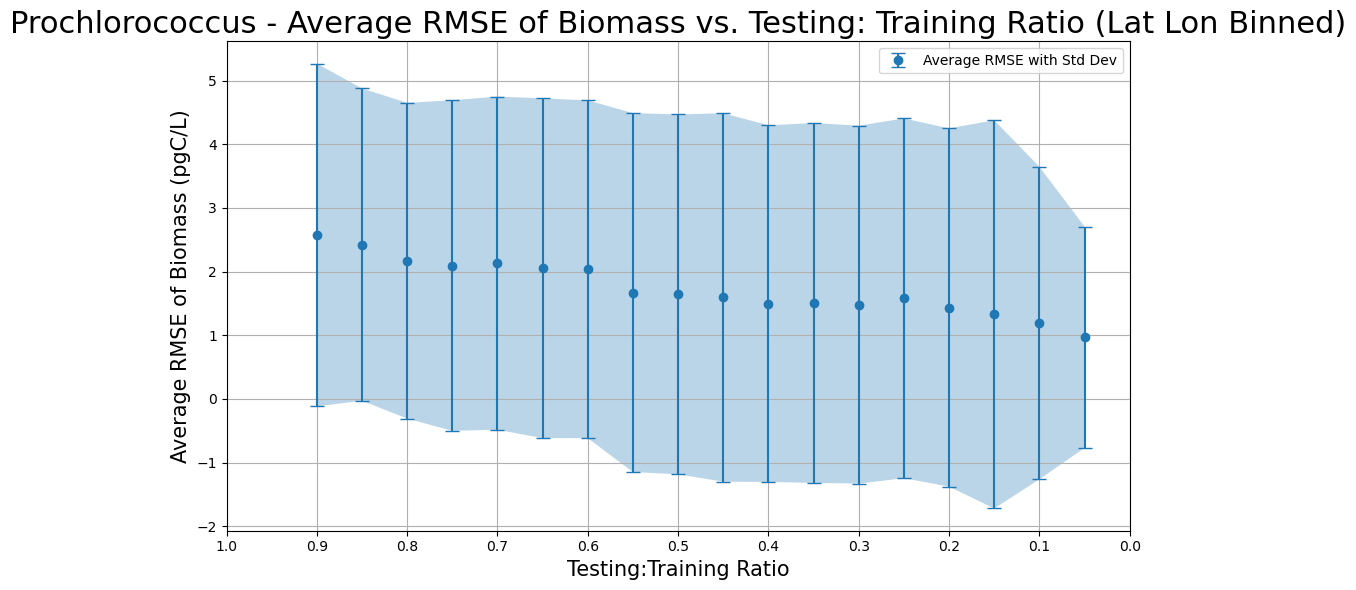

In [19]:
# Assuming you have the necessary data and feature_list defined

# Call the bin_data_and_train function
result = testing_training_ratio(
    features=features_pro,
    labels=labels_pro,
    lat=lat_pro,
    lon=lon_pro,
    feature_list=feature_list_pro,
    title_prefix='Prochlorococcus'
)
# +0.75 RMSE vs original at 0.7 testing/trainging ratio

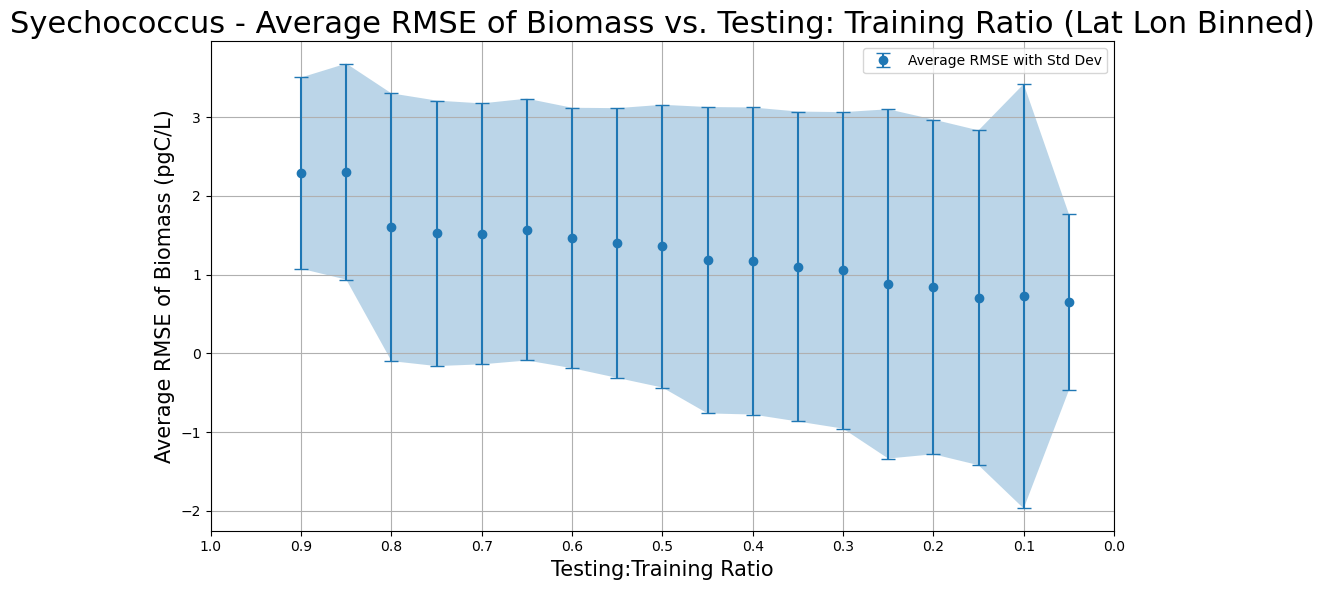

In [20]:
# Call the bin_data_and_train function
result = testing_training_ratio(
    features=features_syn,
    labels=labels_syn,
    lat=lat_syn,
    lon=lon_syn,
    feature_list=feature_list_pico,
    title_prefix='Syechococcus'
)

# +0.25 RMSE vs original at 0.7 testing/trainging ratio

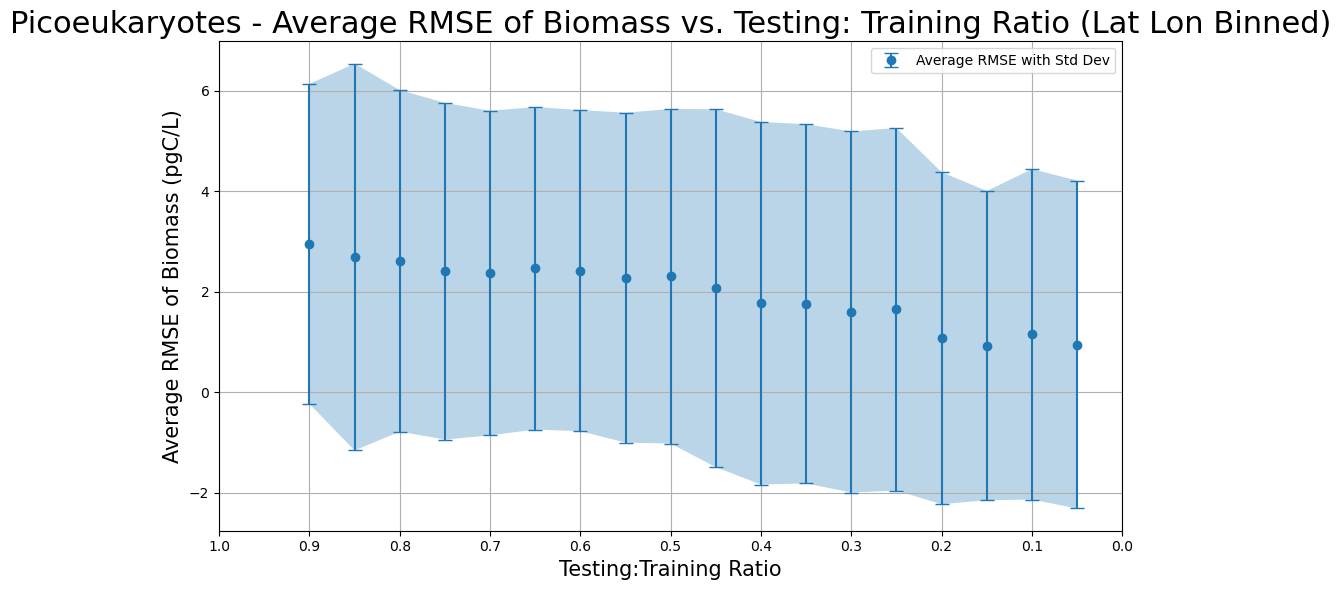

In [21]:
# Call the bin_data_and_train function
result = testing_training_ratio(
    features=features_pico,
    labels=labels_pico,
    lat=lat_pico,
    lon=lon_pico,
    feature_list=feature_list_syn,
    title_prefix='Picoeukaryotes'
)
# +0.3 RMSE vs original at 0.7 testing/trainging ratio

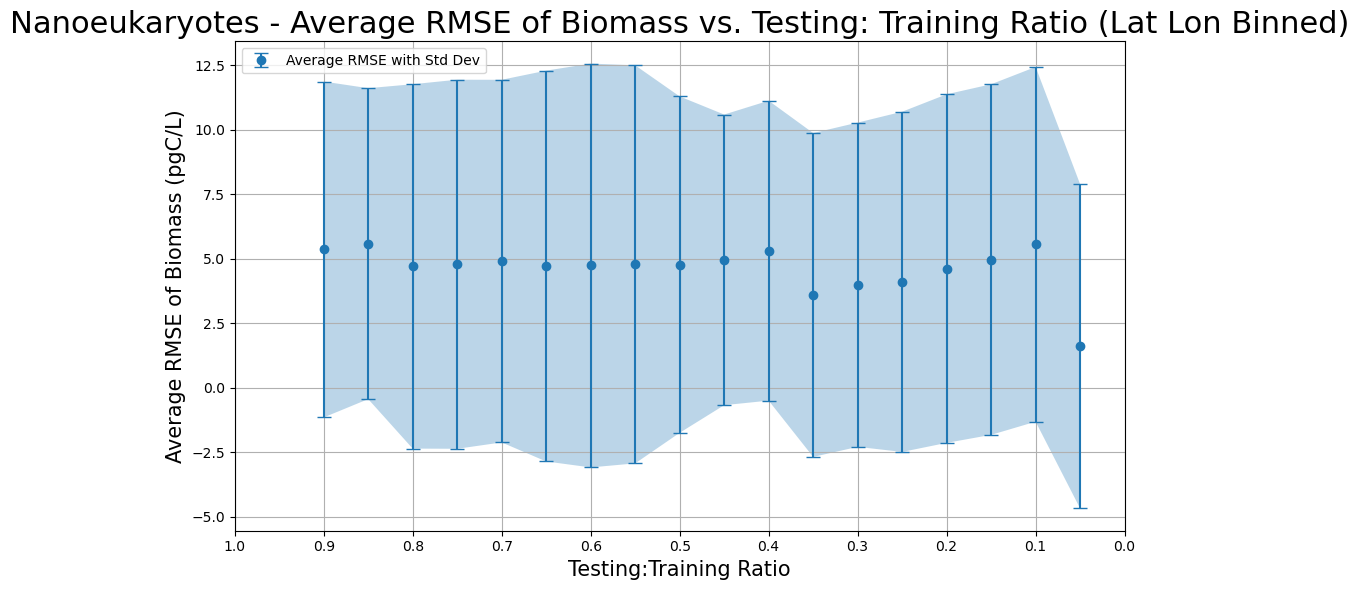

In [22]:
# Call the bin_data_and_train function
result = testing_training_ratio(
    features=features_nano,
    labels=labels_nano,
    lat=lat_nano,
    lon=lon_nano,
    feature_list=feature_list_nano,
    title_prefix='Nanoeukaryotes'
)
# +2 RMSE vs original at 0.7 testing/trainging ratio

### Original function!!!

In [42]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def testing_training_ratio(features, labels, feature_list, title_prefix):
    """
    Used in specific random forest model notebooks. This function graphs the Root Mean Square Error (RMSE) vs.
    the ratio to testing to training data. Aim is to choose the highest testing to training ratio where the RMSE
    starts to fall most dramatically in value. Keeping a higher testing to training ratio keeps our model more
    generalizable prevent overfitting.
    """
    # Graphs the RMSE of different testing and training ratios
    results = {'Test_Ratio': [], 'RMSE': [], 'RMSE_STD': []}
    
    range_list = [i / 20.0 for i in range(1, 19)] + [0.9][:-1]

    for ratio in range_list:
        ratio = round(ratio, ndigits=2)
        results['Test_Ratio'].append(ratio)
        # Using train_test_split to manipulate the training to testing ratio
        train_features, test_features, train_labels, test_labels = train_test_split(
            features, labels, test_size=ratio, random_state=42
        )
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(train_features, train_labels)

        # Use the forest's predict method on the test data
        predictions = rf.predict(test_features)

        # Calculate the root mean square error (RMSE)
        rmse = mean_squared_error(test_labels, predictions, squared=False)
        results['RMSE'].append(np.mean(rmse))  # Take the average of RMSE values
    

        # Calculate the standard deviation of residuals values
        
        std_ = np.std(predictions)
        results['STD'].append(rmse_std)

    # Extract Test Ratios and RMSEs from the dictionary
    test_ratios = results['Test_Ratio']
    rmse_values = results['RMSE']
    rmse_std_values = results['Residuals_STD']

    # Line plot of test ratios and average RMSE
    plt.figure(figsize=(10, 6))
    plt.errorbar(test_ratios, rmse_values, yerr=rmse_std_values, fmt='o', capsize=5, label='Average RMSE with Std Dev')

    # Fill the area under the curve
    plt.fill_between(test_ratios, np.array(rmse_values) - np.array(rmse_std_values), np.array(rmse_values) + np.array(rmse_std_values), alpha=0.3)

    plt.xlabel('Testing:Training Ratio', fontsize=15)
    plt.ylabel('Average RMSE of Biomass (pgC/L)', fontsize=15)
    plt.title(f"{title_prefix} - Average RMSE of Biomass vs. Testing: Training Ratio", fontsize=22)

    plt.xlim(0, 1)
    plt.xticks([i / 10 for i in range(11)])
    plt.gca().invert_xaxis()

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results, 



## Defining a function to plot out-of-bag error (OOB) againts number of trees in random forest model

This function tests different numbers of trees used in the random forest model and finds the OOB for each number of trees.  This is then called in each population-specific notebook to find the optimal number of trees for that population's model.  

In [10]:
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

def plot_oob_error_vs_num_trees(train_features, train_labels, title_prefix):
    """
    Developes a plot of Out of Bag (oob) error vs the number of trees grown in a random forest model. There are
        three labeled lines within the plot one representing.
    
    Max features represent the amount of all features (varaibles we are predicting on) used for each 
        tree in the random forest. n = all features.
    
    Warm start = true:reuse the solution of the previous call to fit and add more
        estimators to the ensemble, otherwise, just fit a whole new forest.
        
    oob_score = True: Use out-of-bag samples to estimate the generalization score. By default, r2_score is used.
        Provide a callable with signature.
    
    random state: controls random number generator that is used to shuffle/split the data. Ensures the same
        randomization is used each time the code is ran.
    
    """
    RANDOM_STATE = 42

    ensemble_clfs = [
        (
            "max_features='sqrt(n)'",
            RandomForestRegressor(
                warm_start=True,
                max_features="sqrt",
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "max_features='1/3 n'",
            RandomForestRegressor(
                warm_start=True,
                max_features=1/3,
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "max_features= n",
            RandomForestRegressor(
                warm_start=True,
                max_features=None,
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
    ]

    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    min_estimators = 15
    max_estimators = 128

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1, 5):
            clf.set_params(n_estimators=i)
            clf.fit(train_features, train_labels)
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("# of Trees")
    plt.ylabel("OOB error rate (1 - R^2)")
    plt.legend(loc="upper right")
    plt.suptitle(f"{title_prefix} - Out-of-Bag Error Rate vs. Number of Trees in Random Forest Regression")
    plt.show()


## Defining functions to compare predicted biomass with actual data

These functions give us a preliminary look at how well the model is predicting biomass.  These are called in each of the population specific notebooks.  

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import seaborn as sns

def plot_model_predictions():
    """
    Creates two plots. First a Line density plot with the Root Mean Square Percentage Error (RMSPE) displayed 
    with two line density placments one for predicted and one for actual values. The second plot displayes a 
    scatter density plot of predicted vs true values with a linear regression line.
    """
    
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import mean_absolute_error
    import seaborn as sns

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # First subplot: Line Density Plot
    ax1 = axes[0]
    mae = mean_absolute_error(test_labels, predictions)
    sns.histplot(x=test_labels, fill=True, color="blue", label="True Values", ax=ax1)
    sns.histplot(x=predictions, fill=True, color="red", label="Predictions", ax=ax1)
    ax1.text(0.05, 0.9, 'RMSPE = {:.2f}%'.format(percentage_RMSE), transform=ax1.transAxes, fontsize=20)
    ax1.set_xlabel('Biomass (pgC per L)')
    ax1.set_ylabel('Density')
    ax1.grid(True)
    ax1.legend()

    # Second subplot: Scatter Plot with Linear Regression Line
    ax2 = axes[1]
    ax2.set_xlabel('Actual Biomass (pgC per L)')
    ax2.set_ylabel('Predicted Biomass (pgC per L)')
    ax2.set_ylim(0, max(test_labels.max(), predictions.max())-5)
    ax2.set_xlim(0, max(test_labels.max(), predictions.max())-5)
    ax2.set_aspect('equal')
    ax2.grid(True)

    
    # PRO Model Predictions vs True Values
    sns.kdeplot(x=test_labels, y=predictions, shade=True, cmap="Reds", ax=ax2)
    ax2.set_aspect('equal')
    ax2.grid(True)

    # Add linear regression line
    x = test_labels
    y = predictions
    slope, intercept = np.polyfit(x, y, 1)
    ax2.plot(x, slope*x + intercept, color='blue', label='Linear Regression')
    
    # Add black dashed one-to-one line
    max_val = max(test_labels.max(), predictions.max())
    ax2.plot([0, max_val], [0, max_val], linestyle='--', color='black', label='One-to-One')


    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    
    return fig, axes



In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import seaborn as sns

def plot_model_predictions_density():
    """
    Displayes a  scatter density plot of predicted vs true values with a linear regression line in addition
    to a one-to-one line that displays a proportionate relationship
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import mean_absolute_error
    import seaborn as sns

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))


    # Scatter Plot with Linear Regression Line
    ax.set_xlabel('Actual Biomass (pgC per L)', fontsize=24)
    ax.set_ylabel('Predicted Biomass (pgC per L)', fontsize=24)
    ax.set_ylim(0, max(test_labels.max(), predictions.max())-5)
    ax.set_xlim(0, max(test_labels.max(), predictions.max())-5)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.text(0.05, 0.9, 'RMSPE = {:.2f} %'.format(percentage_RMSE), transform=ax.transAxes, fontsize=20)
    
    
    # PRO Model Predictions vs True Values
    sns.kdeplot(x=test_labels, y=predictions, shade=True, cmap="Reds", ax=ax)
    ax.set_aspect('equal')
    ax.grid(True)

    # Add linear regression line
    x = test_labels
    y = predictions
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='blue', label='Linear Regression')
    
    # Add black dashed one-to-one line
    max_val = max(test_labels.max(), predictions.max())
    ax.plot([0, max_val], [0, max_val], linestyle='--', color='black', label='One-to-One')


    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    
    return fig, ax

